## Problem Statement:

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

 

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.
 

Variable  Description

Item_Identifier - Unique product ID

Item_Weight - Weight of product

Item_Fat_Content - Whether the product is low fat or not

Item_Visibility - The % of total display area of all products in a store allocated to the particular product

Item_Type - The category to which the product belongs

Item_MRP - Maximum Retail Price (list price) of the product

Outlet_Identifier - Unique store ID

Outlet_Establishment_Year - The year in which store was established

Outlet_Size - The size of the store in terms of ground area covered

Outlet_Location_Type - The type of city in which the store is located

Outlet_Type - Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales - Sales of the product in the particulat store. This is the outcome variable to be predicted.


## Evaluation Metric:

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in "SampleSubmission.csv".

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.


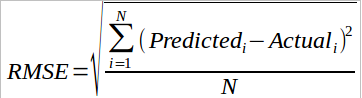

Where,
N: total number of observations
Predicted: the response entered by user
Actual: actual values of sales

Also, note that the test data is further divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. But, the final rankings will be based on score on Private data set. Since this is a practice problem, we will keep declare winners after specific time intervals and refresh the competition.



In [22]:
import numpy as np
from scipy.stats import mode
# import statistics
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, LabelEncoder, scale

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.pipeline import Pipeline
import datetime

# from ipynb.fs.full.model_fcns import data_info,data_cleaning,data_scale, data_scale2, data_encoding

%matplotlib inline

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print("test: {0} train: {1} combine data: {2}".format(test.shape,train.shape, data.shape))
test = data[data.source=='test']
train = data[data.source=='train']
# train.head(10)
# test.head(10)
data.tail(10)

C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



test: (5681, 12) train: (8523, 13) combine data: (14204, 13)


,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
14194,reg,FDA01,59.5904,NaN,Canned,0.054463,15.00,1999,OUT049,Tier 1,Medium,Supermarket Type1,test
14195,Low Fat,NCH42,231.1010,NaN,Household,0.036594,6.86,1999,OUT049,Tier 1,Medium,Supermarket Type1,test
14196,Low Fat,FDF46,116.0834,NaN,Snack Foods,0.094053,7.07,2009,OUT018,Tier 3,Medium,Supermarket Type2,test
14197,Low Fat,DRL35,43.2770,NaN,Hard Drinks,0.030704,15.70,1997,OUT046,Tier 1,Small,Supermarket Type1,test
14198,Regular,FDW46,63.4484,NaN,Snack Foods,0.070411,13.00,1999,OUT049,Tier 1,Medium,Supermarket Type1,test
14199,Regular,FDB58,141.3154,NaN,Snack Foods,0.013496,10.50,1997,OUT046,Tier 1,Small,Supermarket Type1,test
14200,Regular,FDD47,169.1448,NaN,Starchy Foods,0.142991,7.60,2009,OUT018,Tier 3,Medium,Supermarket Type2,test
14201,Low Fat,NCO17,118.7440,NaN,Health and Hygiene,0.073529,10.00,2002,OUT045,Tier 2,NaN,Supermarket Type1,test
14202,Regular,FDJ26,214.6218,NaN,Canned,0.000000,15.30,2007,OUT017,Tier 2,NaN,Supermarket Type1,test
14203,Regular,FDU37,79.7960,NaN,Canned,0.104720,9.50,2002,OUT045,Tier 2,NaN,Supermarket Type1,test


## 1. EDA

In [23]:
# check null/missing, duplicate/mislabeled, categorical
def data_info(data):
    data.info()
    
    # print(data.isnull())
    print("\n\n---NULL COUNTS----\n", data.apply(lambda x: sum(x.isnull())), "\n\n")
    
    #print(data.apply(lambda x: len(x.unique())))
    
    for col in data.select_dtypes(include=['object']).columns:
        print(col,  ":\n",  (data[col].unique()).shape,  data[col].unique())
    for col in data.select_dtypes(exclude=['object']).columns:
        print(col,  ": ",  (data[col].unique()).shape)

In [24]:
data_info(train)
# data_info(test)
# data_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 13 columns):
Item_Fat_Content             8523 non-null object
Item_Identifier              8523 non-null object
Item_MRP                     8523 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    8523 non-null object
Item_Visibility              8523 non-null float64
Item_Weight                  7060 non-null float64
Outlet_Establishment_Year    8523 non-null int64
Outlet_Identifier            8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Size                  6113 non-null object
Outlet_Type                  8523 non-null object
source                       8523 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 932.2+ KB


---NULL COUNTS----
 Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales               0
Item_Type         

In [25]:
#  Item_Identifier: have large no of unique value,and sothey have small no of examples to train.
#                   t/f careful by not one-hot encoding and use other features for meaningful use/merge.
#  Item_Type: also have large no of categories. check frequency of each to see if enough examples in each categories.
#             If not in some than try to merge with other --> for cleaning/pre-processing, feature engineering
for col in ["Item_Type", "Outlet_Identifier","Outlet_Size","Outlet_Location_Type", "Outlet_Type"]:
    print('\nFrequency of Categories for varible : %s'%col)
    print(train[col].value_counts())
    print("nan/null    ",sum(train[col].isnull()))


Frequency of Categories for varible : Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
nan/null     0

Frequency of Categories for varible : Outlet_Identifier
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
nan/null     0

Frequency of Categories for varible : Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
nan/null     2410

Frequency of Categories for v

## 2. Data Preprocessing

In [26]:
#data cleaning
def data_cleaning(data):
    
    # imputing null/missing values   (null:Outlet_Size,Item_Visibility    and   missing:Item_Weight)
    data['Outlet_Size'].fillna('Small',inplace=True)
    data['Item_Weight'].fillna((data['Item_Weight'].mean()), inplace=True)
    
    # rectify mislabeled/missing data points
    cleanup= {"Item_Fat_Content": {'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'},
              "Item_Visibility": {0:np.mean(data['Item_Visibility'])}
             }
    data.replace(cleanup,inplace= True)
    
    data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']     # datetime.date.today().year
    
    return data

def data_cleaning2(data):
    
#     ## 1. Item_Weight: imputing NULL based on MEAN weight of items with same Item_Identifier
    item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier', aggfunc=np.mean)
    print(item_avg_weight['Item_Weight'][data["Item_Identifier"][0]])
    count=0
    for x in [x for x in data['Item_Weight'].index if pd.isnull(data["Item_Weight"][x])]:  
        count+=1
        data["Item_Weight"][x]= item_avg_weight['Item_Weight'][item_avg_weight.index == data["Item_Identifier"][x]]
    else:
        print(count," number of null values in Item_Weight imputed")

#     isWtNull= data['Item_Weight'].isnull()
#     index= [x for x in isWtNull.index if isWtNull[x] == True]
#     print(data['Item_Weight'][pd.isnull(data['Item_Weight'])])
#     data['Item_Weight'][pd.isnull(data['Item_Weight'])] = data['Item_Identifier'][pd.isnull(data['Item_Weight'])].apply(
#         lambda x: item_avg_weight[x])
#     data.loc[isWtNull,'Item_Weight'] = data.loc[isWtNull,'Item_Identifier'].apply(lambda x: item_avg_weight[x])
#     print(sum(data['Item_Weight'].isnull())  )
    
    
    ## 2. Item_Visibility: imputing ZERO based on MEAN visibility of item with same Item_Identifier
    item_avg_vis = data.pivot_table(values='Item_Visibility', index='Item_Identifier', aggfunc=np.mean)
    print(item_avg_vis['Item_Visibility'][data["Item_Identifier"][0]])
    count=0
    for x in [x for x in data['Item_Visibility'].index if data["Item_Visibility"][x] == 0]:  
        count+=1
        data["Item_Visibility"][x]= item_avg_vis['Item_Visibility'][item_avg_vis.index == data["Item_Identifier"][x]]
    else:
        print(count," number of zero values in Item_Visibility imputed")
    
    
    ## 3. Outlet_Size: imputing NULL based on MODE size of item with same Item_Identifier
    outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x.dropna()).mode[0]))
    print(outlet_size_mode[data["Outlet_Type"][0]][0])
#     outlet_size_mode = data.pivot_table(values='Outlet_Size', index='Outlet_Type',aggfunc=(lambda x:mode(x.dropna()).mode[0]))
#     print(outlet_size_mode['Outlet_Size'][data["Outlet_Type"][0]])
    count=0
    for x in [x for x in data['Outlet_Size'].index if pd.isnull(data["Outlet_Size"][x])]:  
        count+=1
        data["Outlet_Size"][x]= outlet_size_mode[data["Outlet_Type"][x]][0]
#         data["Outlet_Size"][x]= outlet_size_mode['Outlet_Size'][data["Outlet_Type"][x]]
    else:
        print(count," number of null values in Outlet_Size imputed")
    
    
    ## 4. Item_Fat_Content: rectify mislabeling in 
    data["Item_Fat_Content"].replace(['LF','low fat','reg'],['Low Fat','Low Fat','Regular'],inplace= True)
    

    ## 5. Outlet_Establishment_Year: mofify
    data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
    
    return data

In [27]:
data= data_cleaning2(data)
data_2= data

9.299999999999999


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2439  number of null values in Item_Weight imputed
0.017235185222222223


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


879  number of zero values in Item_Visibility imputed


C:\Users\MyPC\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Small


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


4016  number of null values in Outlet_Size imputed


In [145]:
data= data_2

In [146]:
train=data[data.source== "train"]
test=data[data.source== "test"]
Y= train.Item_Outlet_Sales
X= train.drop(["Item_Outlet_Sales"], axis=1)
# train = pd.concat([X,Y], axis =1 )
# data = pd.concat([train, test],ignore_index=True)
# X.head(10)
X.describe()                                #Therefore, data appears to have no outliners.

,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,140.992782,0.069941,12.873623,15.168133
std,62.275067,0.049856,4.645893,8.371760
min,31.290000,0.003575,4.555000,4.000000
25%,93.826500,0.031228,8.785000,9.000000
50%,143.012800,0.057249,12.600000,14.000000
75%,185.643700,0.097383,16.850000,26.000000
max,266.888400,0.328391,21.350000,28.000000


## 3. Feature Engineering

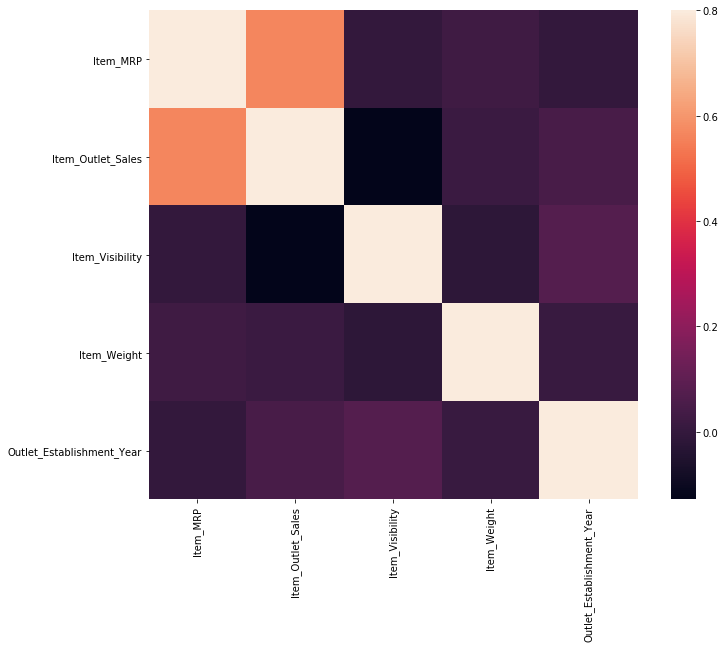

In [147]:
# mylist = list(X.select_dtypes(include=['object']).columns)
# X_obj= X[mylist]
# X_num= X.drop(mylist, axis=1)

corr= (train.select_dtypes(include=[np.number])).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True)

In [148]:
# plt.figure(figsize=(12,7))
# sns.set(style="whitegrid", color_codes=True)
# sns.distplot(train.Item_Outlet_Sales, bins = 25)

In [149]:
# plt.figure(figsize=(12,7))
# sns.set(style="whitegrid", color_codes=True)
# sns.pairplot(X, hue="Item_Fat_Content")
# sns.pairplot(data=train, x_vars=["Item_Type", "Outlet_Identifier","Outlet_Size","Outlet_Location_Type", "Outlet_Type"],
#              y_vars=["Item_Outlet_Sales"], hue="Outlet_Size")
# sns.pairplot(data=train, x_vars=["Item_Type", "Outlet_Identifier","Outlet_Size","Outlet_Location_Type", "Outlet_Type"],
#              y_vars=["Item_Outlet_Sales"], hue="Outlet_Location_Type")
# sns.pairplot(data=train, x_vars=["Item_Type", "Outlet_Identifier","Outlet_Size","Outlet_Location_Type", "Outlet_Type"],
#              y_vars=["Item_Outlet_Sales"], hue="Outlet_Type")
# sns.pairplot(data=train, x_vars=(X.select_dtypes(include=[np.number])).columns, 
#              y_vars=["Item_Outlet_Sales"], hue="Item_Fat_Content")
# sns.pairplot(data=train, y_vars=X_obj.columns, x_vars=["Item_Identifier"], hue="Item_Fat_Content")

In [150]:
# Outlet_Type and [ Outlet_Identifier, Outlet_Size, Outlet_Location_Type ] seems to be highly related

# train.pivot_table(values=['Outlet_Type', 'Outlet_Size','Outlet_Location_Type'], columns='Outlet_Identifier',
#                   aggfunc=lambda x:x.unique())
# train.groupby('Item_Type')['Item_Identifier'].unique()
# fat_items= train.groupby('Item_Fat_Content')['Item_Type'].unique()
# print(fat_items,"\n",fat_items[0],"\n",fat_items[1])
# train.pivot_table(columns='Outlet_Type', values='Outlet_Size', aggfunc=lambda x:x.unique())
# train.pivot_table(values='Outlet_Location_Type', columns='Outlet_Type',aggfunc=lambda x:x.mode())
# train.pivot_table(values='Item_Weight', columns='Item_Identifier') # aggr func is mean(numerical data) by default

In [151]:
for col in ["Outlet_Identifier","Outlet_Size","Outlet_Location_Type", "Outlet_Type"]:
    print('\nFrequency of Categories for varible : %s'%col)
    print(train[col].value_counts())
    print("nan/null    ",sum(train[col].isnull()))


Frequency of Categories for varible : Outlet_Identifier
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
nan/null     0

Frequency of Categories for varible : Outlet_Size
Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64
nan/null     0

Frequency of Categories for varible : Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64
nan/null     0

Frequency of Categories for varible : Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64
nan/null     0


In [152]:
data['Item_Type_Identifier']=data.Item_Identifier.str.slice(stop=3) 
# print(data.Item_Type_Identifier.unique())
print(data.groupby('Item_Type_Identifier')['Item_Type'].unique())

Item_Type_Identifier
DRA                                        [Soft Drinks]
DRB                                        [Soft Drinks]
DRC                                 [Soft Drinks, Dairy]
DRD                                 [Soft Drinks, Dairy]
DRE                                 [Soft Drinks, Dairy]
DRF                    [Soft Drinks, Dairy, Hard Drinks]
DRG                    [Dairy, Hard Drinks, Soft Drinks]
DRH                    [Soft Drinks, Dairy, Hard Drinks]
DRI                    [Hard Drinks, Soft Drinks, Dairy]
DRJ                    [Hard Drinks, Soft Drinks, Dairy]
DRK                    [Hard Drinks, Soft Drinks, Dairy]
DRL                           [Soft Drinks, Hard Drinks]
DRM                           [Hard Drinks, Soft Drinks]
DRN                           [Hard Drinks, Soft Drinks]
DRO                                        [Hard Drinks]
DRP                                        [Hard Drinks]
DRQ                                        [Hard Drinks]
DRY       

In [153]:
def feature_modification(data):
    ## features with low freq or lage no of sub-categories: Item_Type, Item_Identifier
    ## T/f combine if mean behaviour(eg sales) is same and/or create new feature with broad categories
    data.Item_Type_Identifier = data.Item_Identifier.str.slice(stop=2)
#     data['Item_Type_Identifier'] = data['Item_Identifier'].apply(lambda x: x[0:2])
    data["Item_Type_Identifier"].replace(['FD','DR','NC'],['Food','Drinks','Household'],inplace= True)
#     data['Item_Type_Identifier'] = data['Item_Type_Identifier'].map({'FD':'Food','NC':'Household','DR':'Drinks'})

    return data
    
def data_encoding(data):
    ## Item_Fat_Content, Outlet_Size :Do we need to treat them as Ordinal Categorical var(and use Label encoding) ?????????
#     le = LabelEncoder()
#     (data[["Item_Fat_Content", "Outlet_Size"]])= (data[["Item_Fat_Content", "Outlet_Size"]]).apply(le.fit_transform)
    
    ## convert Nominal Categorical variable into numeric values(using one-hot encoding)
    mylist = [col for col in data.select_dtypes(include=['object']).columns if col not in 
              ["Item_Identifier","Item_Type","source"]]
    dummies = pd.get_dummies(data[mylist], prefix= mylist, columns= mylist,
                             drop_first= False)   # drop_first= True to remove multicollinearity   
    data.drop([x for x in mylist if x not in ['Outlet_Identifier']], axis=1, inplace = True)
    data = pd.concat([data,dummies], axis =1 )
    
    return data

def data_scale(data):
    X= data.drop(["Item_Outlet_Sales"], axis=1)
    Y= data.Item_Outlet_Sales
    X_obj= X.select_dtypes(exclude=np.number)
    X_num= X.select_dtypes(include=np.number)
    train_X=X[X.source == "train"]
    scaler= MinMaxScaler()
    # scaler= StandardScaler()
    # scaler= Normalizer()
    scaler.fit(train_X.select_dtypes(include=np.number))
    X_num_scaled =scaler.transform(X_num)
    X_num= pd.DataFrame(X_num_scaled, columns=list(X_num.columns))
    return pd.concat([X_num,Y,X_obj], axis =1 )

In [154]:
# data Normalize(useful if sparse data)/scaling(fast optimization, Regularization)/Standardize(Dim redn)
data= data_scale(data)
data.head(10)

,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Identifier
0,0.927507,0.038399,0.282525,0.416667,3735.1380,Low Fat,FDA15,Dairy,OUT049,Tier 1,Medium,Supermarket Type1,train,FDA
1,0.072068,0.048346,0.081274,0.000000,443.4228,Regular,DRC01,Soft Drinks,OUT018,Tier 3,Medium,Supermarket Type2,train,DRC
2,0.468288,0.040593,0.770765,0.416667,2097.2700,Low Fat,FDN15,Meat,OUT049,Tier 1,Medium,Supermarket Type1,train,FDN
3,0.640093,0.043901,0.871986,0.458333,732.3800,Regular,FDX07,Fruits and Vegetables,OUT010,Tier 3,Small,Grocery Store,train,FDX
4,0.095805,0.019104,0.260494,0.916667,994.7052,Low Fat,NCD19,Household,OUT013,Tier 3,High,Supermarket Type1,train,NCD
5,0.085361,0.164659,0.347723,0.000000,556.6088,Regular,FDP36,Baking Goods,OUT018,Tier 3,Medium,Supermarket Type2,train,FDP
6,0.111923,0.028220,0.541530,0.916667,343.5528,Regular,FDO10,Snack Foods,OUT013,Tier 3,High,Supermarket Type1,train,FDO
7,0.324587,0.381432,0.860077,1.000000,4022.7636,Low Fat,FDP10,Snack Foods,OUT027,Tier 3,Medium,Supermarket Type3,train,FDP
8,0.278791,0.040369,0.693361,0.291667,1076.5986,Regular,FDH17,Frozen Foods,OUT045,Tier 2,Small,Supermarket Type1,train,FDH
9,0.664399,0.279773,0.871986,0.083333,4710.5350,Regular,FDU28,Frozen Foods,OUT017,Tier 2,Small,Supermarket Type1,train,FDU


In [155]:
# feature modification and One_hot Encoding of Categorical var
data= feature_modification(data)
data_3=data

In [156]:
data= data_3
data= data_encoding(data)
data.head(10)

,Item_MRP,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier,Item_Type,Outlet_Identifier,source,Item_Fat_Content_Low Fat,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Identifier_Drinks,Item_Type_Identifier_Food,Item_Type_Identifier_Household
0,0.927507,0.038399,0.282525,0.416667,3735.1380,FDA15,Dairy,OUT049,train,1,...,0,1,0,0,1,0,0,0,1,0
1,0.072068,0.048346,0.081274,0.000000,443.4228,DRC01,Soft Drinks,OUT018,train,0,...,0,1,0,0,0,1,0,1,0,0
2,0.468288,0.040593,0.770765,0.416667,2097.2700,FDN15,Meat,OUT049,train,1,...,0,1,0,0,1,0,0,0,1,0
3,0.640093,0.043901,0.871986,0.458333,732.3800,FDX07,Fruits and Vegetables,OUT010,train,0,...,0,0,1,1,0,0,0,0,1,0
4,0.095805,0.019104,0.260494,0.916667,994.7052,NCD19,Household,OUT013,train,1,...,1,0,0,0,1,0,0,0,0,1
5,0.085361,0.164659,0.347723,0.000000,556.6088,FDP36,Baking Goods,OUT018,train,0,...,0,1,0,0,0,1,0,0,1,0
6,0.111923,0.028220,0.541530,0.916667,343.5528,FDO10,Snack Foods,OUT013,train,0,...,1,0,0,0,1,0,0,0,1,0
7,0.324587,0.381432,0.860077,1.000000,4022.7636,FDP10,Snack Foods,OUT027,train,1,...,0,1,0,0,0,0,1,0,1,0
8,0.278791,0.040369,0.693361,0.291667,1076.5986,FDH17,Frozen Foods,OUT045,train,0,...,0,0,1,0,1,0,0,0,1,0
9,0.664399,0.279773,0.871986,0.083333,4710.5350,FDU28,Frozen Foods,OUT017,train,0,...,0,0,1,0,1,0,0,0,1,0


In [157]:
#save processed data in train-test CSV files for furthur use
data= data.drop(["Item_Type"], axis=1)

train=data[data.source== "train"]
test=data[data.source== "test"]

train.drop(['source'],axis=1,inplace=True)
test.drop(['source', 'Item_Outlet_Sales'],axis=1,inplace=True)

train.to_csv("data/train_modified.csv",index=False)
test.to_csv("data/test_modified.csv",index=False)

C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## 4.1 Fitting model : Without any Dim Redn

In [183]:
# data(labeled) split
train = pd.read_csv('data/train_modified.csv')
test = pd.read_csv('data/test_modified.csv')
# print(train.columns,'\n', test.columns)
    
Y= train.Item_Outlet_Sales
X= train.drop(["Item_Outlet_Sales"], axis=1)
x_train, x_cv, y_train, y_cv = train_test_split(X,Y, test_size =0.3)
outs=pd.DataFrame(np.asarray(y_cv),columns=["y_cv"])

predictors= [col for col in test.columns if col not in ['Item_Identifier','Outlet_Identifier',]]
print(predictors)

# if data not scaled/normalized/std earlier
# col= x_cv.columns
## col = [col for col in train.columns if col not in ['Item_Outlet_Sales']]
# x_train = pd.DataFrame(scale(x_train), columns=col, index=x_train.index)
# x_cv = pd.DataFrame(scale(x_cv), columns=col, index=x_cv.index)

['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3', 'Item_Type_Identifier_Drinks', 'Item_Type_Identifier_Food', 'Item_Type_Identifier_Household']


In [184]:
def modelPrediction(algo, filename, predictors):
    algo.fit(x_train[predictors],y_train)
    pred_cv= algo.predict(x_cv[predictors])
    # evaluation using r-square and mean square error
    rmse = np.sqrt(np.mean((pred_cv - y_cv)**2))
    r2e =lreg.score(x_cv[predictors],y_cv)
    print(rmse,r2e)
#     outs= pd.concat([outs,pd.DataFrame(np.asarray(pred_cv, dtype=float), columns=["pred_cv_"+filename]) ], axis=1)
    pred_test= test[['Item_Identifier','Outlet_Identifier']]
    pred_test["Item_Outlet_Sales"]=algo.predict(test[predictors])
    pred_test.to_csv(filename+".csv",index=False)
    return pred_test,pred_cv

In [185]:
#-----------Baseline Model(algos must perform better than this)----------------#
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

base1.to_csv("baseline.csv",index=False)

C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1112.6629552600373 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


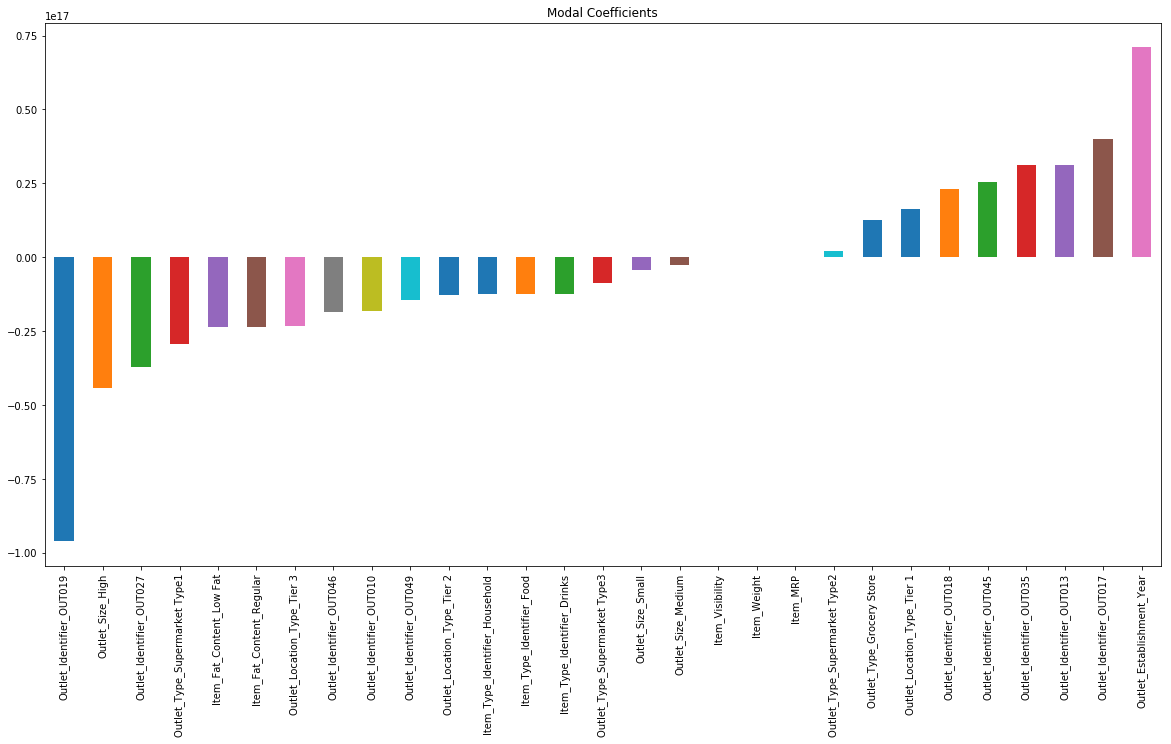

In [186]:
#----------------Linear Regression--------------------#

lreg = LinearRegression(normalize=True)
pred_test,pred_cv= modelPrediction(lreg,"LinReg", predictors)
# print(outs)

# print(type(y_cv), type(pred_cv))
# print((np.append([np.asarray(y_cv)], [pred_cv], axis=0)))
# print(y_cv.index.values.tolist())

#coefficientsvof regression model
coef = Series(lreg.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients',figsize=(20,10))

Text(0.5,1,'Residual plot')

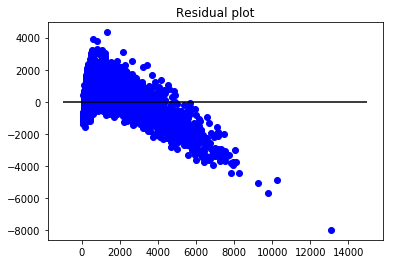

In [187]:
#residual plot
x_plot = plt.scatter(y_cv, (pred_cv - y_cv), c='b')

plt.hlines(y=0, xmin= -1000, xmax=15000)
plt.title('Residual plot')

1112.860095488333 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


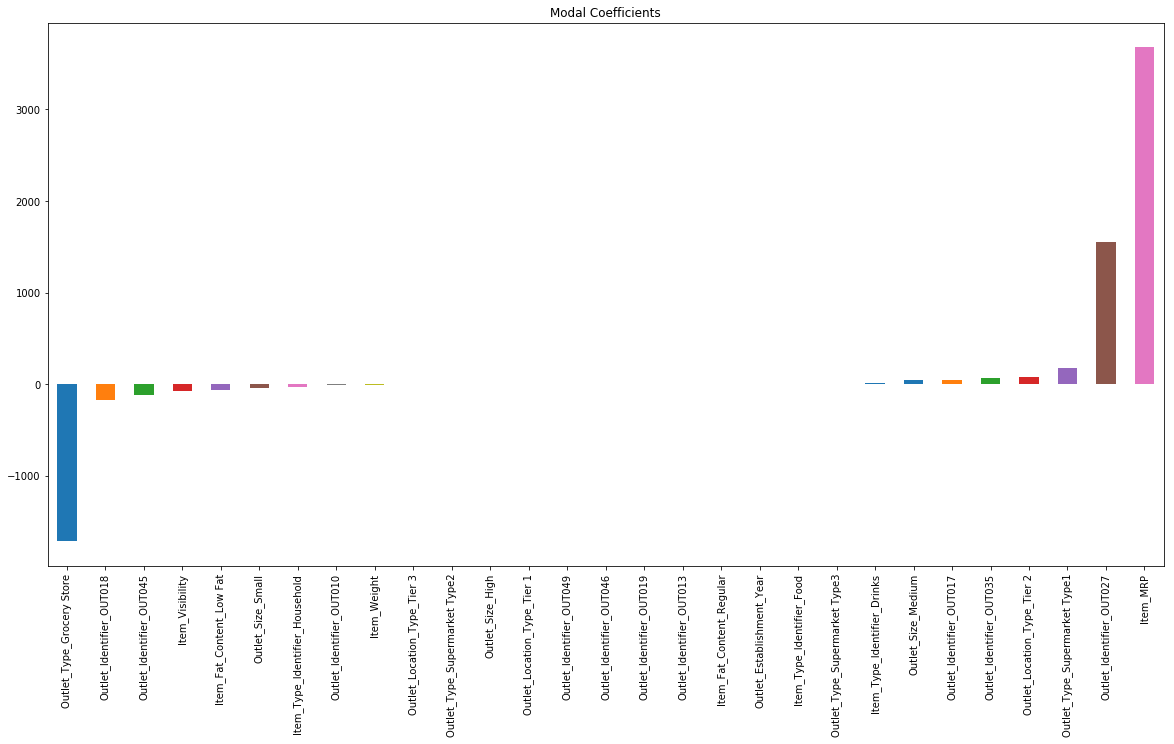

1112.784188402741 0.5641811535509921


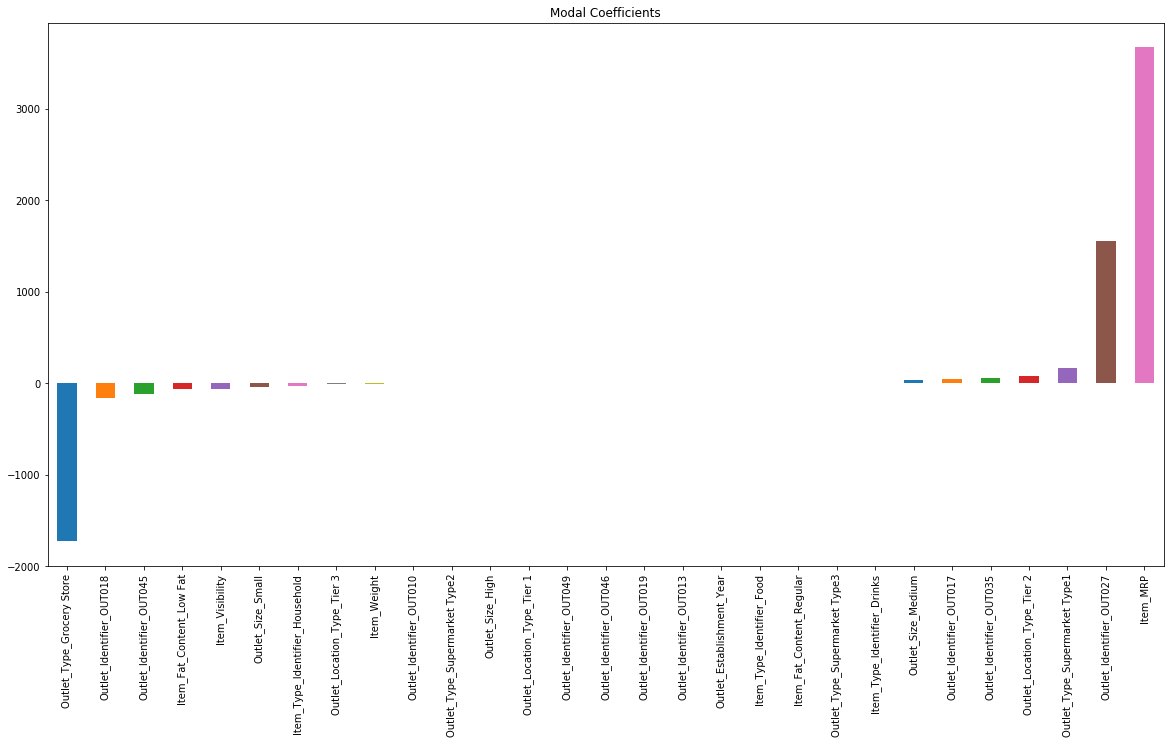

1113.3812041790045 0.5641811535509921


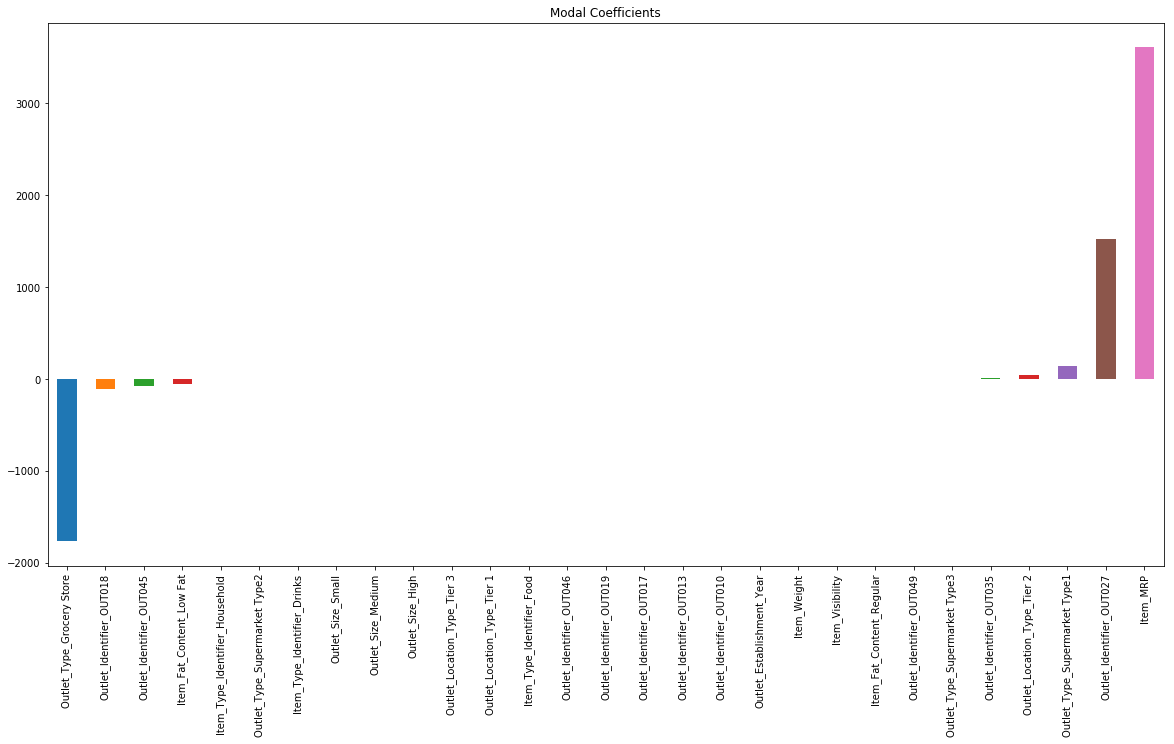

1120.192624384433 0.5641811535509921


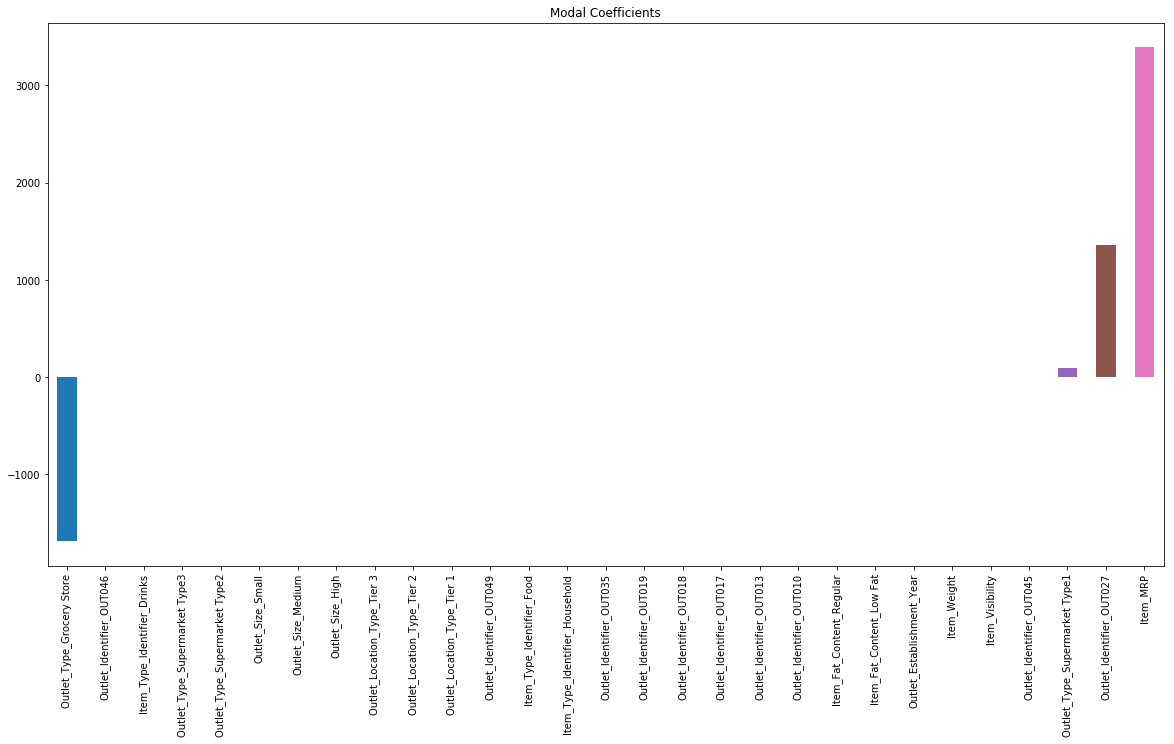

In [199]:
#-----------------LASSO Regression-------------#

for alpha in [0.05,0.5,5,20]:
    lareg = Lasso(alpha, max_iter=5000)
#     lareg.fit(x_train,y_train)
#     pred_cv= lareg.predict(x_cv)
#     rmse = np.sqrt(np.mean((pred_cv - y_cv)**2))
#     r2e =lareg.score(x_cv,y_cv)
#     print(alpha,rmse,r2e)
#     outs= pd.concat([outs,pd.DataFrame(np.asarray(pred_cv, dtype=float), columns=["pred_cv_"+"Lasso_"+str(alpha)])], axis=1)
    pred_test,pred_cv= modelPrediction(lareg,"LasReg"+str(alpha), predictors)
    
    #coefficients of LASSO regression model
    coef = Series(lareg.coef_,predictors).sort_values()
    coef.plot(kind='bar', title='Modal Coefficients',figsize=(20,10))
    plt.show()

1112.8685911943467 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


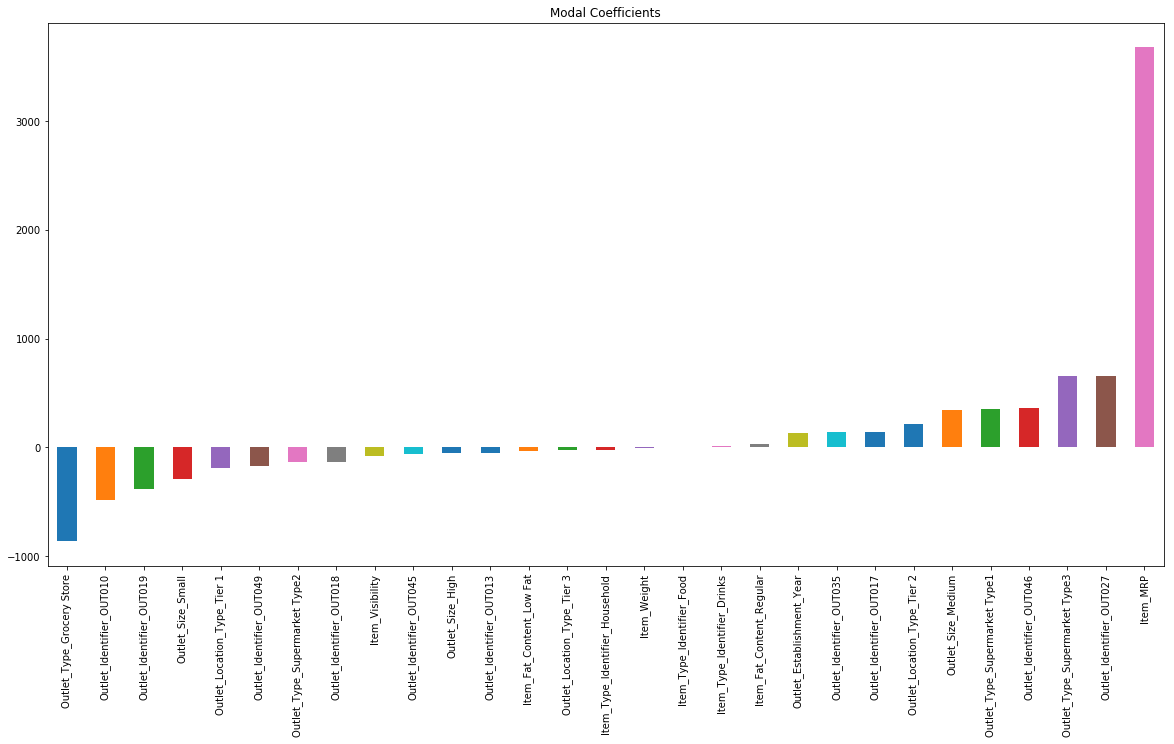

1112.8549166614932 0.5641811535509921


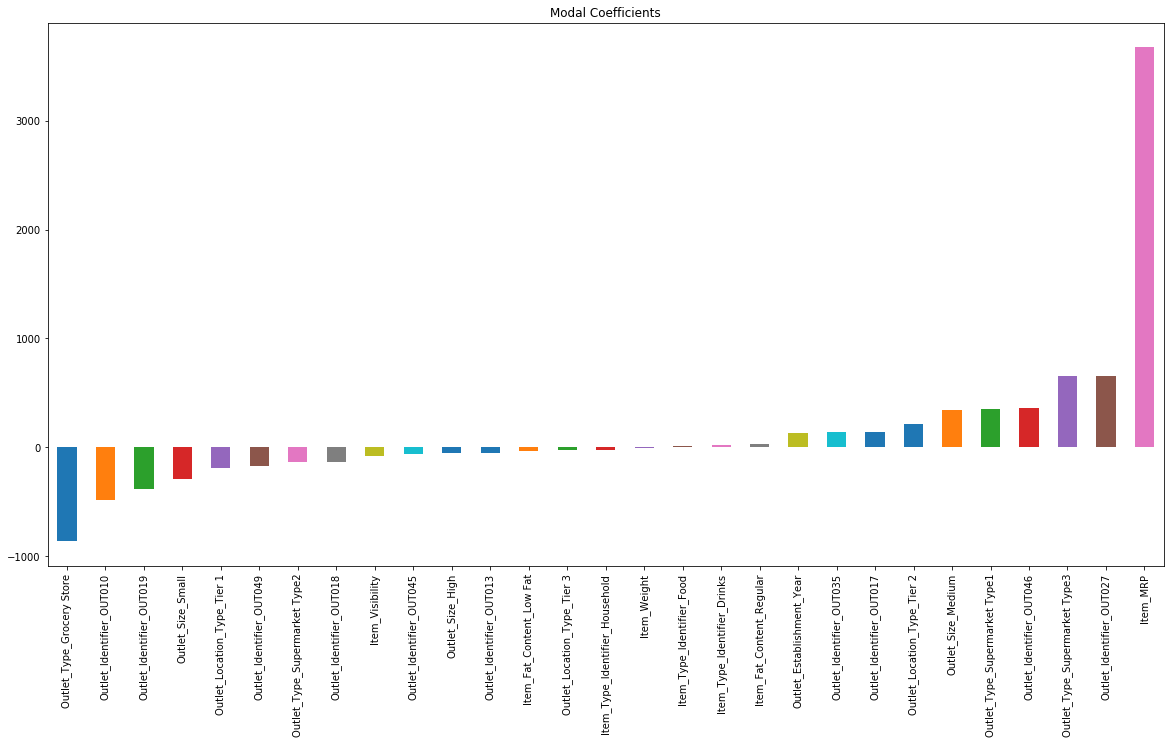

1112.778280535726 0.5641811535509921


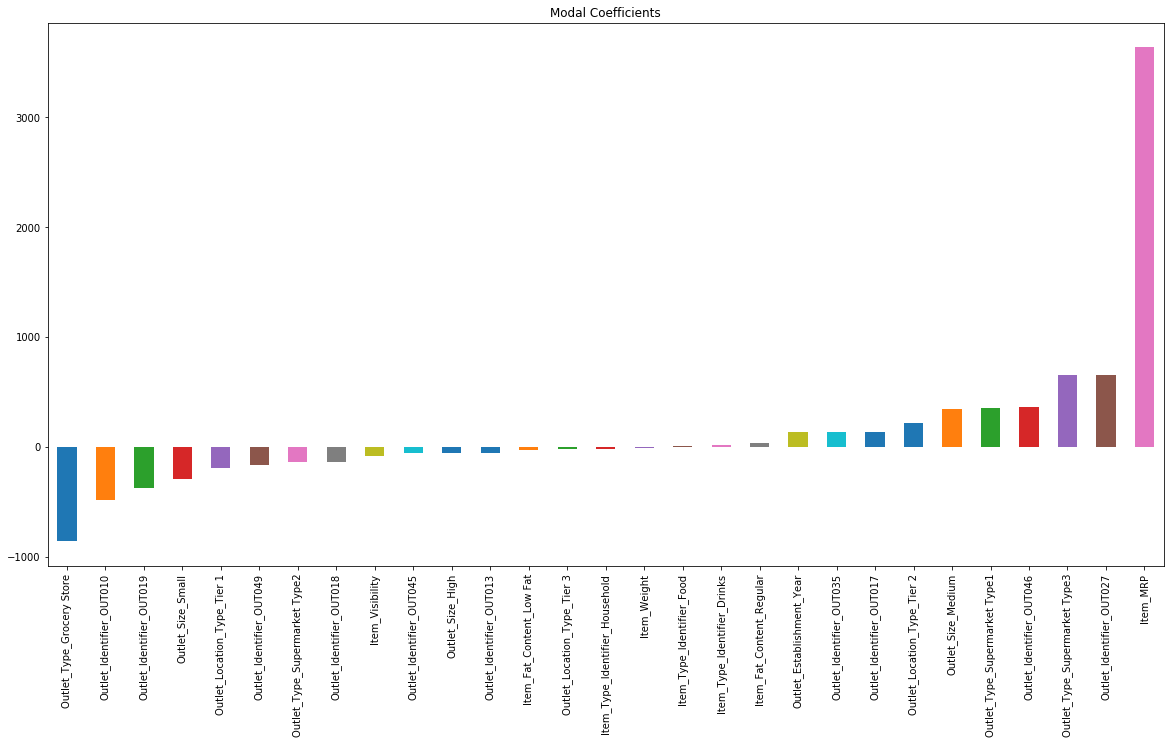

1113.2437214491 0.5641811535509921


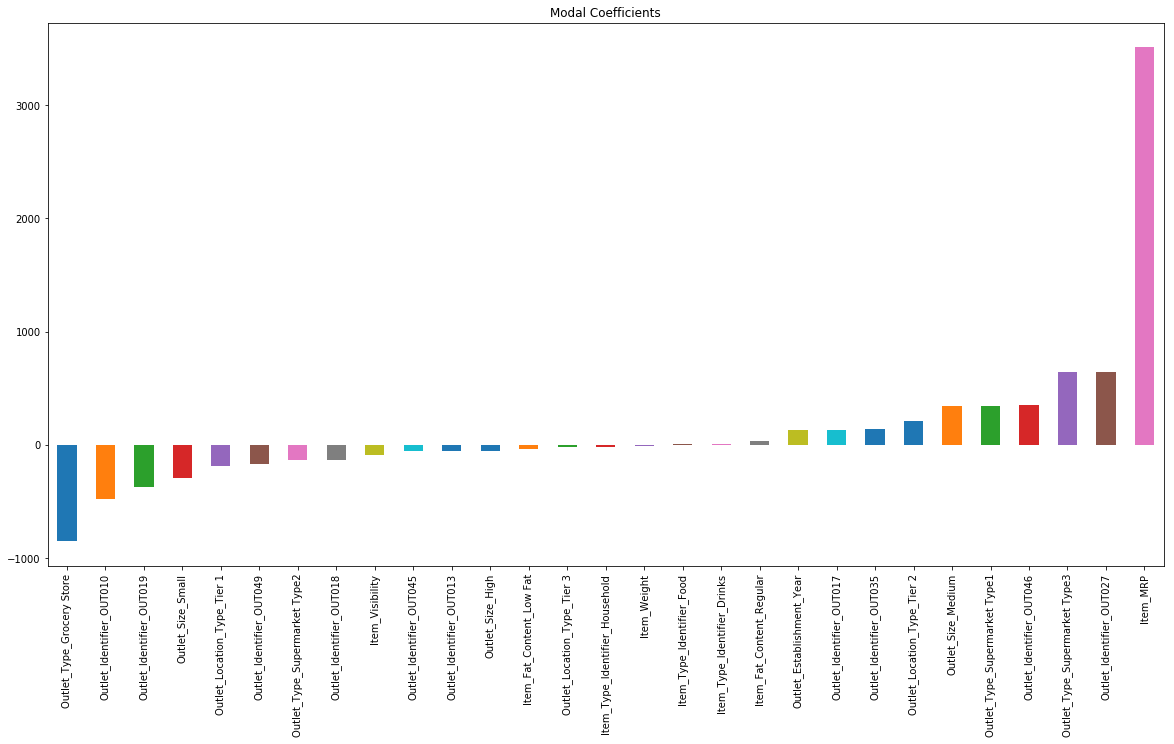

In [196]:
#-----------------Ridge Regression-------------#

for alpha in [0.05,0.5,5,20]:
    rreg = Ridge(alpha, max_iter=5000)
    pred_test,pred_cv= modelPrediction(rreg,"RdgReg"+str(alpha), predictors)
    
    #coefficients of Ridge regression model
    coef = Series(rreg.coef_,predictors).sort_values()
    coef.plot(kind='bar', title='Modal Coefficients',figsize=(20,10))
    plt.show()

In [197]:
#-----------------ElasticNet Regression-------------#

for alpha in [0.005,0.05,0.5,5]:
    elreg = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=5000)
    pred_test,pred_cv= modelPrediction(rreg,"ENetReg"+str(alpha), predictors)

1113.2437214491 0.5641811535509921
1113.2437214491 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


1113.2437214491 0.5641811535509921
1113.2437214491 0.5641811535509921


1093.7899559389587 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


1091.7386038024288 0.5641811535509921


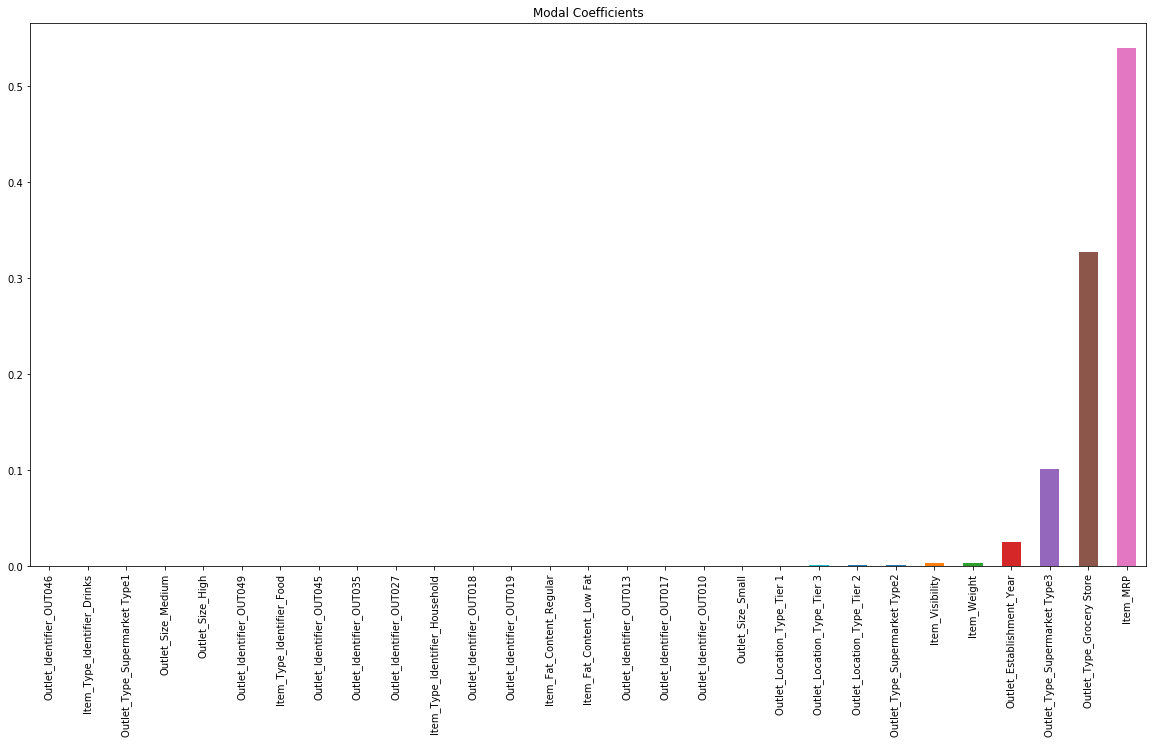

In [201]:
#-----------------Decision Tree-------------#

for d in [15,8]:
    dtree = DecisionTreeRegressor(max_depth=d, min_samples_leaf=100)
    pred_test,pred_cv= modelPrediction(dtree,"DTree"+str(d), predictors)
    coef = Series(dtree.feature_importances_,predictors).sort_values()
    coef.plot(kind='bar', title='Modal Coefficients',figsize=(20,10))
#     plt.show()

200 5
1081.4185487250304 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


400 6
1080.4294038215082 0.5641811535509921


C:\Users\MyPC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


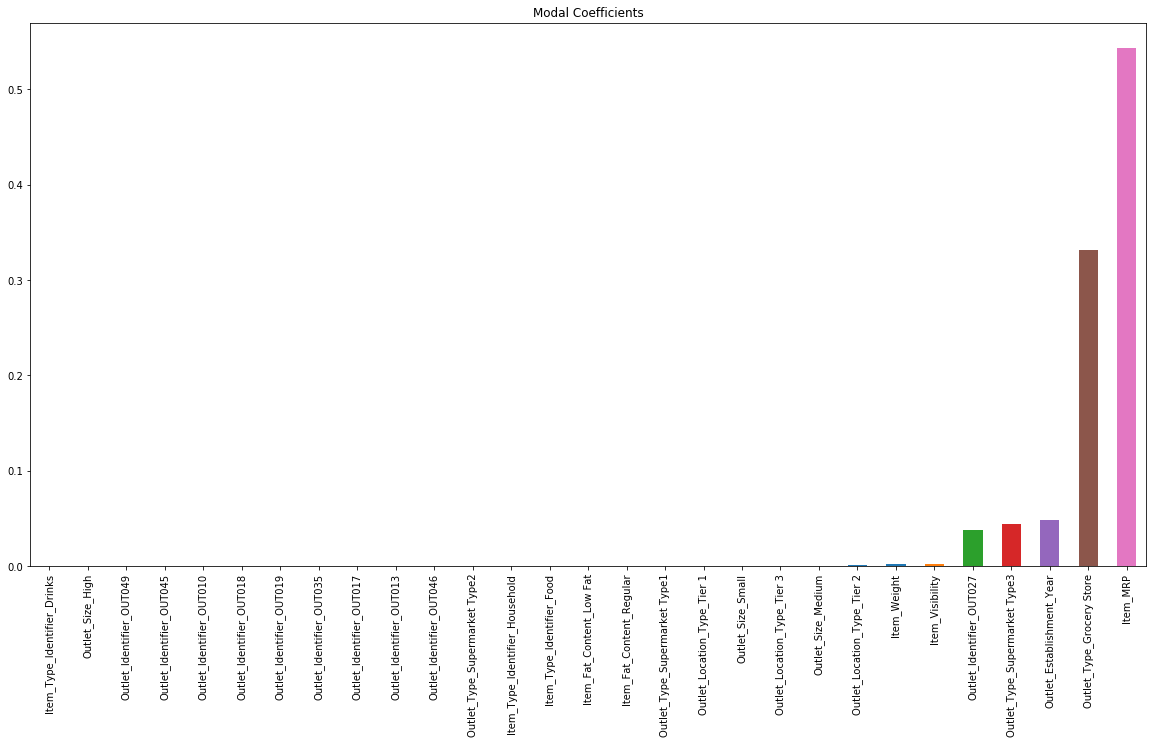

In [203]:
#-----------------Random Forest-------------#

for e,d in [[200,5],[400,6]]:
    rforest = RandomForestRegressor(n_estimators=e,max_depth=d, min_samples_leaf=100,n_jobs=4)
    pred_test,pred_cv= modelPrediction(rforest,"RForest"+str(d), predictors)
    coef = Series(rforest.feature_importances_,predictors).sort_values()
    coef.plot(kind='bar', title='Modal Coefficients',figsize=(20,10))

##  4.2 Fitting model : With Dim Redn before regression model

In [ ]:
# steps = [
#     ('scale', StandardScaler()),
#     ('pca', PCA()),
#     ('estimator', LinearRegression())
# ]
# pipe = Pipeline(steps)
# pca = pipe.set_params(pca__n_components=3)
# pca.fit(X, y)

pca = PCA(n_components=10)
X_reduced = pca.fit_transform(scale(X))
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
# pca.fit(x_train)
# reduced_train= pca.transform(x_train)
# reduced_cv= pca.transform(x_cv)

# tsvd= TruncatedSVD(n_components=10)
# X_reduced = tsvd.fit_transform(scale(X))
# print(np.cumsum(np.round(tsvd.explained_variance_ratio_, decimals=4)*100))


# print(type(X_reduced))
reduced_train = X_reduced[x_train.index,:]
reduced_cv = X_reduced[x_cv.index,:]

lreg = LinearRegression()
lreg.fit(reduced_train,y_train)
pred_cv= lreg.predict(reduced_cv)
rmse = np.sqrt(np.mean((pred_cv - y_cv)**2))
r2e =lreg.score(reduced_cv,y_cv)
print(rmse,r2e)
outs= pd.concat([outs,pd.DataFrame(np.asarray(pred_cv, dtype=float), columns=["pred_cv_"+"DRLRegr"]) ], axis=1)

x_plot = plt.scatter(y_cv, (pred_cv - y_cv), c='b')
plt.hlines(y=0, xmin= -1000, xmax=15000)
plt.title('Residual plot')

In [ ]:
for alpha in [0.05,0.5,5,20]:
    rreg = Ridge(alpha, max_iter=5000)
    rreg.fit(reduced_train,y_train)
    pred_cv= rreg.predict(reduced_cv)
    rmse = np.sqrt(np.mean((pred_cv - y_cv)**2))
    r2e =rreg.score(reduced_cv,y_cv)
    print(alpha,rmse,r2e)
    outs= pd.concat([outs,pd.DataFrame(np.asarray(pred_cv, dtype=float), columns=["pred_cv_"+"DRRidge_"+str(alpha)])], axis=1)

In [ ]:
print(outs.head(20))

Types of Regularization Techniques :(https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)

Let’s recall, both in ridge and lasso we added a penalty term, but the term was different in both cases. In ridge, we used the squares of theta while in lasso we used absolute value of theta. So why these two only, can’t there be other possibilities?

Actually, there are different possible choices of regularization with different choices of order of the parameter in the regularization term, which is denoted by . This is more generally known as Lp regularizer.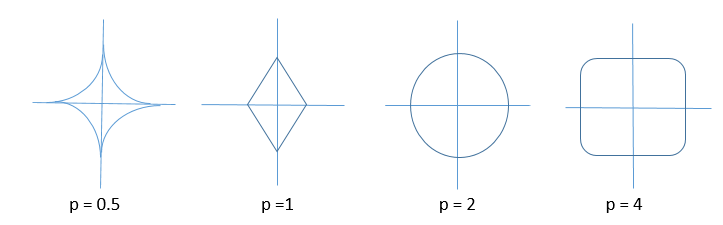

Let us try to visualize some by plotting them. For making visualization easy, let us plot them in 2D space. For that we suppose that we just have two parameters. Now, let’s say if p=1, we have term as  . Can’t we plot this equation of line? Similarly plot for different values of p are given below.
In the above plots, axis denote the parameters(Θ1 and Θ2). Let us examine them one by one.

For p=0.5, we can only get large values of one parameter only if other parameter is too small. For p=1, we get sum of absolute values where the increase in one parameter Θ is exactly offset by the decrease in other. For p =2, we get a circle and for larger p values, it approaches a round square shape.

The two most commonly used regularization are in which we have p=1 and p=2, more commonly known as L1 and L2 regularization.

Look at the figure given below carefully. The blue shape refers the regularization term and other shape present refers to our least square error (or data term).

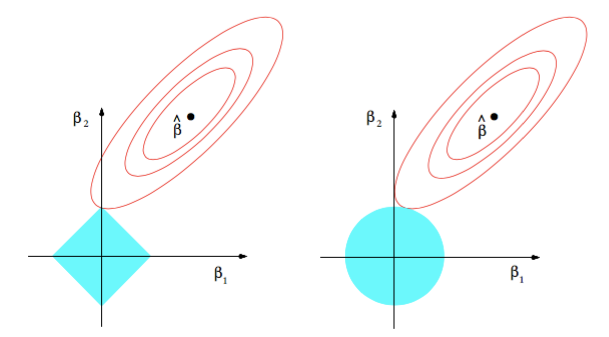
The first figure is for L1 and the second one is for L2 regularization. The black point denotes that the least square error is minimized at that point and as we can see that it increases quadratically as we move from it and the regularization term is minimized at the origin where all the parameters are zero .

Now the question is that at what point will our cost function be minimum? The answer will be, since they are quadratically increasing, the sum of both the terms will be minimized at the point where they first intersect.

Take a look at the L2 regularization curve. Since the shape formed by L2 regularizer is a circle, it increases quadratically as we move away from it. The L2 optimum(which is basically the intersection point) can fall on the axis lines only when the minimum MSE (mean square error or the black point in the figure) is also exactly on the axis. But in case of L1, the L1 optimum can be on the axis line because its contour is sharp and therefore there are high chances of interaction point to fall on axis. Therefore it is possible to intersect on the axis line, even when minimum MSE is not on the axis. If the intersection point falls on the axes it is known as sparse.

Therefore L1 offers some level of sparsity which makes our model more efficient to store and compute and it can also help in checking importance of feature, since the features that are not important can be exactly set to zero.